#  Introduction

In [1]:
from src.tools.data_processing.dataLoader import DataLoader
from src.tools.data_processing.dataExplorer import DataExplorer
from src.tools.data_processing.dataHandler import DataHandler
from src.tools.machine_learning.featureSelector import FeatureSelector
from src.tools.machine_learning.dataSplit import DataSplit
from src.tools.machine_learning.algorithms import Algorithms
from src.tools.machine_learning.visualizer import Visualizer
import warnings
warnings.filterwarnings('ignore')

The purpose of this text is to discuss the creation a Machine Learning (ML) model that is able to predict, with a reasonable precision, the life expectancy in a country given the following variables: 

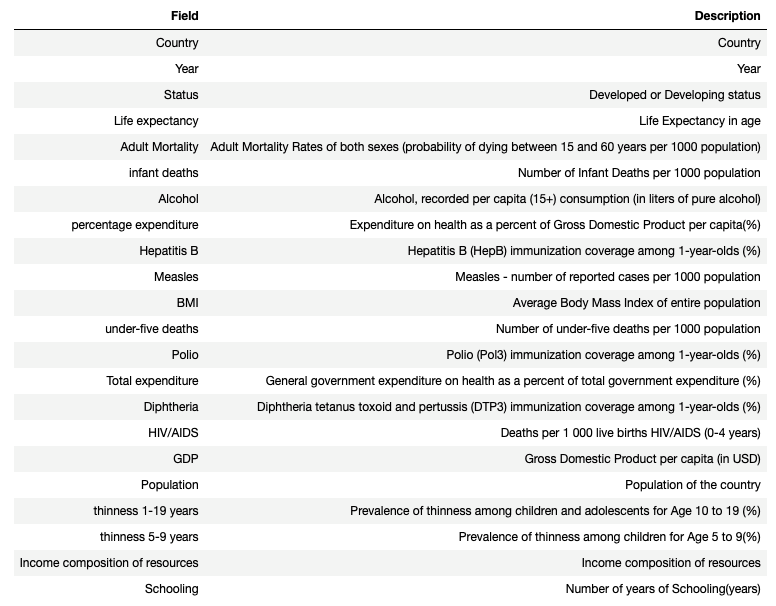

In [2]:
DataLoader.diplay_toc("src/database/dict.png")

The dataset used as basis for this study was found on Kaggle. For more details about each variable and its sources, visit **[this link](https://www.kaggle.com/kumarajarshi/life-expectancy-who)**.

# The Goal

Given a set of specific data about a country, a Machine Learning model that returns the average life expectancy in it must be built.

#  Loading the data

The first step is to load the data set of interest:

In [3]:
database = DataLoader.load_data('src/database/Life_Exp_Data.csv')

Dimensionality: (2938, 22)
Variables:
 Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_mortality',
       'Infant_deaths', 'Alcohol', 'Percentage_expenditure', 'Hepatitis_b',
       'Measles', 'Bmi', 'Under-five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'Hiv/aids', 'Gdp', 'Population', 'Thinness__1-19_years',
       'Thinness_5-9_years', 'Income_composition_of_resources', 'Schooling'],
      dtype='object')


The data ensemble has 2938 rows and 12 columns (that represent characteristics of the countries). The names of those columns will be changed to better describe the data contained in it:

In [4]:
cols_to_rename = {
            "Thinness_5-9_years" : "Thin_5_to_9_y" ,
            "Thinness__1-19_years" : "Thin_10_to_19_y",
            "Measles" : "Measles_cases",
            "Alcohol" : "Alcohol_consumption",
            "percentage expenditure" : "GDP_on_health",
            "Hepatitis_B" : "HepB_vacc",
            "Polio" : "Polio_vacc",
            "Diphtheria" : "Diphtheria_vacc",
            "Schooling": "Years_in_school",
            "Under-five_deaths" : "Deaths_under_5_y",
            "Status": "Development_status",
            "Income_composition_of_resources": "Inc_comp_resources"
}

database = DataLoader.change_col_names(cols_to_rename, database)

Variables:
 Index(['Country', 'Year', 'Development_status', 'Life_expectancy',
       'Adult_mortality', 'Infant_deaths', 'Alcohol_consumption',
       'Percentage_expenditure', 'Hepatitis_b', 'Measles_cases', 'Bmi',
       'Deaths_under_5_y', 'Polio_vacc', 'Total_expenditure',
       'Diphtheria_vacc', 'Hiv/aids', 'Gdp', 'Population', 'Thin_10_to_19_y',
       'Thin_5_to_9_y', 'Inc_comp_resources', 'Years_in_school'],
      dtype='object')


The life expectancy in a country (which is the target variable on this study) is depicted on the column 'Life_expectancy'. Thus, the ML model will have to predict the value on this column.

# Data Exploration

It is common for the original set of data to be populated with inconsistent and/or missing values. The later are listed below:

In [5]:
DataExplorer.find_values(database, None)

The column Life_expectancy has 10 values equal to None.
The column Adult_mortality has 10 values equal to None.
The column Alcohol_consumption has 194 values equal to None.
The column Hepatitis_b has 553 values equal to None.
The column Bmi has 34 values equal to None.
The column Polio_vacc has 19 values equal to None.
The column Total_expenditure has 226 values equal to None.
The column Diphtheria_vacc has 19 values equal to None.
The column Gdp has 448 values equal to None.
The column Population has 652 values equal to None.
The column Thin_10_to_19_y has 34 values equal to None.
The column Thin_5_to_9_y has 34 values equal to None.
The column Inc_comp_resources has 167 values equal to None.
The column Years_in_school has 163 values equal to None.


The columns 'Hepatitis_b' and 'Population' have a considerably large number of 'NA's present in it. For that reason, both will be removed from the dataset and, only after that, the remaining rows containing 'NA' will be discarded. 

In [6]:
database = DataExplorer.drop_nas(database, cols_to_drop = ['Hepatitis_b', 'Population'])

(2301, 20)


Besides NA values, some misplaced zeroes can also cause trouble during this analysis, so they will be removed as well:

In [7]:
DataExplorer.find_values(database, 0)
database = DataExplorer.drop_values_from_cols(database, 0, ['Inc_comp_resources', 'Years_in_school'])

The column Infant_deaths has 668 values equal to 0.
The column Percentage_expenditure has 5 values equal to 0.
The column Measles_cases has 763 values equal to 0.
The column Deaths_under_5_y has 612 values equal to 0.
The column Inc_comp_resources has 104 values equal to 0.
The column Years_in_school has 9 values equal to 0.
(2197, 20)


It is important to highlight that this decision to remove the zeroes was made after the evaluation of the correlation between the target variable 'Life_expectancy' and the predictor variables 'Inc_comp_resources' and 'Years_in_school'. For both predictors, the zeroes represented outliers originated by missing data.

Still on the subject of correlation, the relation between the categorical variable 'Development_status' and Life expectancy is depicted by the following graphic:

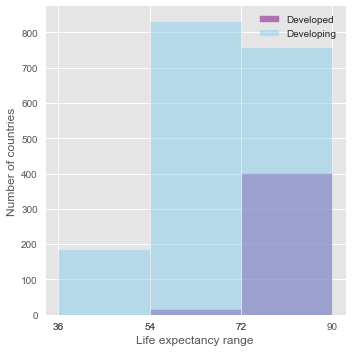

In [8]:
database = DataExplorer.factorize_var(database, 'Development_status')
DataExplorer.visualize_target_var(
    database, 'Life_expectancy',  
    bins = [36, 54, 72, 90], hue = 'Development_status', 
    x_label = 'Life expectancy range', y_label = 'Number of countries', 
    labels = ['Developed', 'Developing']
)

The figure above shows that the life expectancy in developed countries is, for the major part, high (above 72 years). On the other hand, for developing countries, life expectancy is mainly divided between the ranges 54 to 72 and 72 to 90, although a considerable number of members of this group are also in the lower range (36 to 54). Based on that, one can conclude that there is a great inequality among developing countries and that developed countries are more homogeneous with respect to life expectancy.

Aside from the categorical variable mentioned, the data set also contains a series of numeric variables that impact the column Life_expectancy. The ones with the largest correlation coefficients are listed below:

In [9]:
DataExplorer.get_strong_corr(database, 'Life_expectancy', 0.7)

Corr coef between Life_expectancy and Hiv/aids: -0.7685633897435481
Corr coef between Life_expectancy and Inc_comp_resources: 0.9056512090293786
Corr coef between Life_expectancy and Years_in_school: 0.8220577064058471


The result above shows that the correlation regarding Life_expectancy is stronger with the columns 'Hiv/aids', 'Inc_comp_resources' and 'Years_in_School'. Additionally, the following graphic illustrates the strength of the correlation between those and the remaining variables in the dataset:

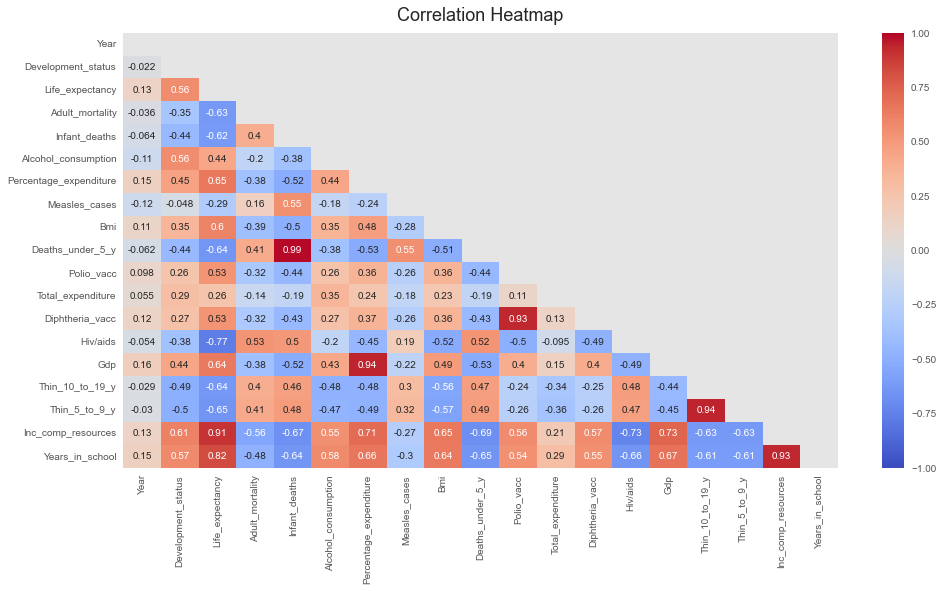

In [10]:
DataExplorer.plot_corr_heatmap(database)

Based on the last figure, one can notice that the columns "Years_in_school", "Inc_comp_resources", "GDP" and "Polio_vacc" have a positive correlation with life expectancy. That is depicted by graphics below:

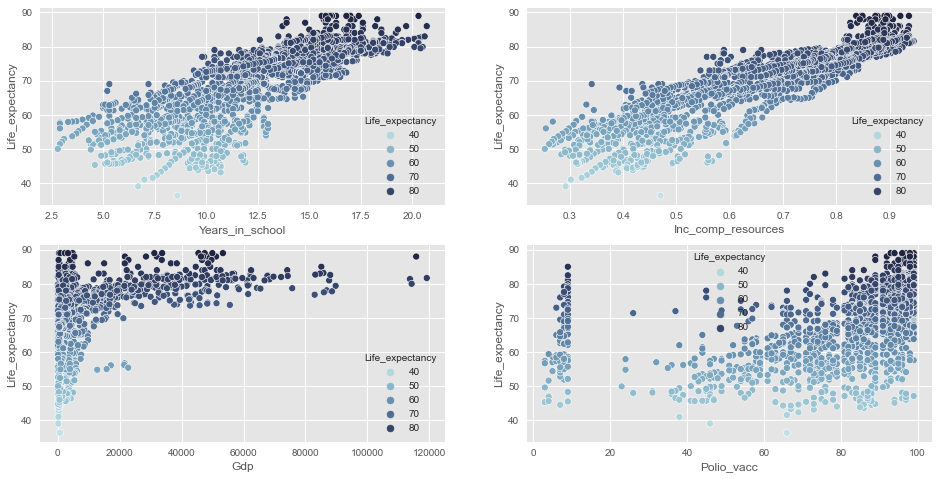

In [11]:
lista_vars = ['Years_in_school', 'Inc_comp_resources', 'Gdp', 'Polio_vacc']
DataExplorer.multiple_var_plot(database, lista_vars, 'Life_expectancy')

Using the above graphics as basis, one can affirm that, in countries where people spend more time in school, the life expectancy is significantly larger. The same can be said about countries with a better income distribution - places where the index 'Income composition of resources' is larger also tend to have citizens with a longer life span.

Moreover, by focusing on the statistically significant region in the graphics, it becomes clear that an increase in the GDP index is also associated with a rise on life expectancy. Finally, regarding the poliomyelitis immunization, something curious happens: a considerable number of countries with a large life expectancy have low levels of immunization. That may be related to a carelessness due to the eradication of polio in those countries or even to the anti-vax movement. Disregarding this group, an increase in polio immunization is followed by an increase in life expectation.

Next, variables with a negative correlation regarding life expectation will be analysed. More specifically, the columns 'Thin_5_to_9_y', 'Thin_10_to_19_y', 'Hiv/aids' and 'Measles_cases'.

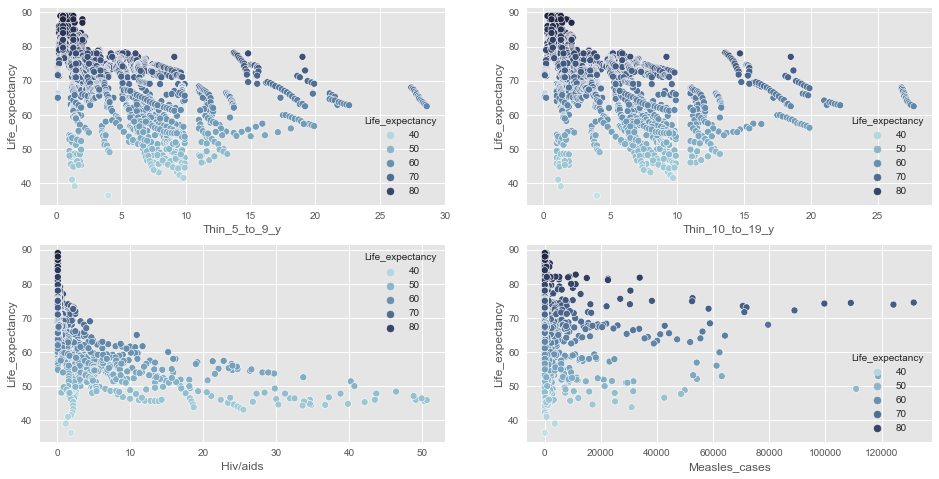

In [12]:
lista_vars2 = ['Thin_5_to_9_y', 'Thin_10_to_19_y', 'Hiv/aids', 'Measles_cases']
DataExplorer.multiple_var_plot(database, lista_vars2, 'Life_expectancy')

On this second set of graphics, the first two are very similar - both point how the prevalence of thinness in different age ranges affect life expectancy. As those indicators decrease, life expectancy rises. 

Furthermore, an increase on the values in the columns 'Hiv/aids' and 'Measles_cases' seem to be linked to an abrupt decrease in life expectancy. It is important to point that, when the Measles variable is highlighted, the correlation is clearly weaker than the one depicted by the other graphics - that is to be expected, since the absolute value of the correlation coefficiente is closer to zero.

Having finished the correlation analysis, it is important to highlight the following: correlation does not imply causality. Even if correlation can be a clue, a deeper study would have to be performed in order to establish a cause and effect relation between two variables.

# Data Manipulation

Right now, each of the numerical variables has a different scale, allowing its values to have distinct amplitudes. Normalization will homogenize the data and improve the ML model performance:

In [13]:
cols_to_norm = database.columns.difference(['Country', 'Life_expectancy'])
scaled_data = DataHandler.min_max_cols(database, cols_to_norm)

Next, it is important to see how the predictor variables are correlated among themselves:

In [14]:
DataHandler.get_strong_corr_predict_vars(scaled_data, 'Life_expectancy', 0.8)             

Corr coef between Deaths_under_5_y and Infant_deaths: 0.9919955655419027
Corr coef between Diphtheria_vacc and Polio_vacc: 0.9320602152421532
Corr coef between Gdp and Percentage_expenditure: 0.9398110287533601
Corr coef between Inc_comp_resources and Years_in_school: 0.9334522739157113
Corr coef between Thin_10_to_19_y and Thin_5_to_9_y: 0.9404924043108513


The results above show that the columns 'Infant_deaths' and 'Deaths_under_5_y' are strongly correlated. Therefore, in order to avoid overfitting, the first will be removed. For a similar reason, the variables 'Gdp' and 'Polio_vacc' will be dropped. Finally, since the name of a country is irrelevant, the variable 'Country' will also be discarded.

In [15]:
scaled_data = scaled_data.drop(['Infant_deaths', 'Gdp', 'Country', 'Polio_vacc', 'Thin_10_to_19_y'], axis = 1)

Other columns with a significantly strong correlation are Inc_comp_resource and Years_in_school. One could argue that those are essentially different characteristics and should both be considered, or that their strong correlation could create problems for the ML model. Nonetheless, the option to keep both variables will be taken.   

Now that the variables are normalized, have the correct type and the undesired columns were removed, the next step is the creation a ML model.

# Machine Learning Models

On this section, two ML models will be created - one using linear regression and another using the random forest algorithm. In both cases, the first step will be the same: to perform a feature selection based on the relevance of each feature.

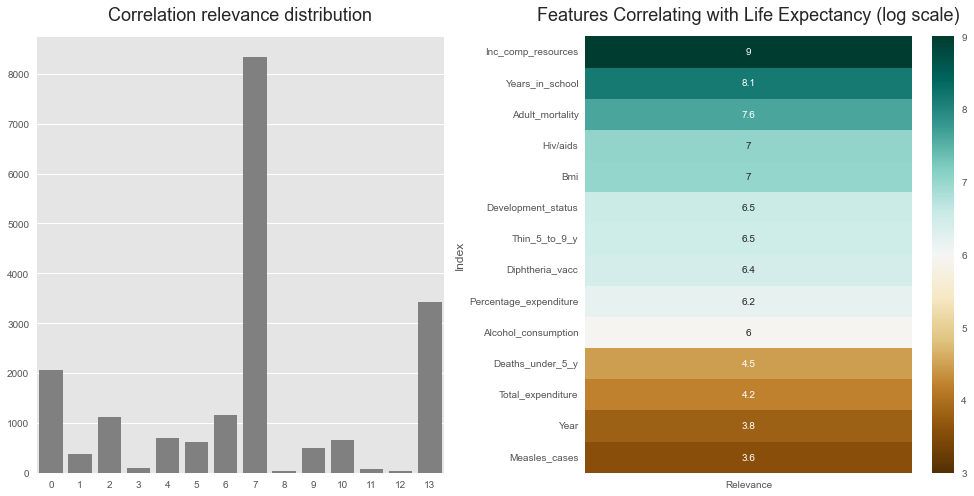

In [16]:
last_col = len(scaled_data.columns) - 1
X = scaled_data.iloc[:, 0:last_col]
Y = scaled_data.iloc[:, last_col]
FeatureSelector.correlation_analysis(scaled_data, 'Life Expectancy', X, Y)

According to the criteria above, the least important variables are 'Measles_cases', 'Year' and 'Total_expenditure'. For that reason, they will be dropped:

In [17]:
X = X.drop(['Year', 'Measles_cases', 'Total_expenditure'], axis = 1)

Next, the data will be divided into a set for training (80%) and a set for testing (20%):

In [18]:
X_train, X_test, Y_train, Y_test = DataSplit.train_test_split(X, Y, 0.2)

## Linear Regression

Using the variables selected up to this point, the linear regression model can be built as follows:

In [19]:
model1 = Algorithms.train_Linear_Regression_model(X_train, Y_train)

R-squared value (training): 0.8882709730916001


The results above indicate that, even though the ML model takes into consideration only part of the variables, the value obtained for R-squared was excelent. Next, the model will be tested using the testing set:

In [20]:
Y_pred = Algorithms.test_Linear_Regression_model(X_test, Y_test, model1)

R-squared value: 0.8927863613765662
Root mean squared error: 3.1587701281420872
Normalized root mean squared error: 0.07466510308780124


The model has been successfully tested and three metrics were obtained: the R-squared, the root mean squared error, and the average root mean squared error. Those results show that the model can predict the data accurately. Additionaly, those metrics will be used in order to compare this model to the others. 

The residues of the model are depicted below:

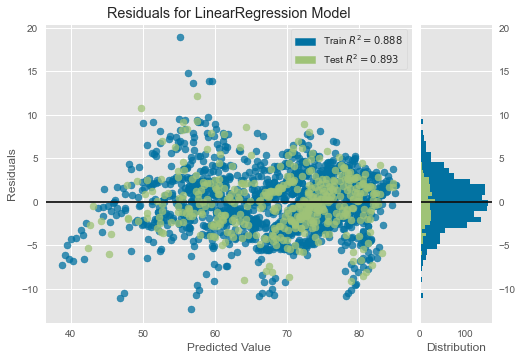

In [21]:
Visualizer.visualize_residue_spread(model1, X_train, X_test, Y_train, Y_test)

The main difference between the predicted and observed values for life expectancy is concentrated around zero, although there are some spread out discrepancies. The residues can also be visualized on the next figure, where the red line indicates the zero residue points:

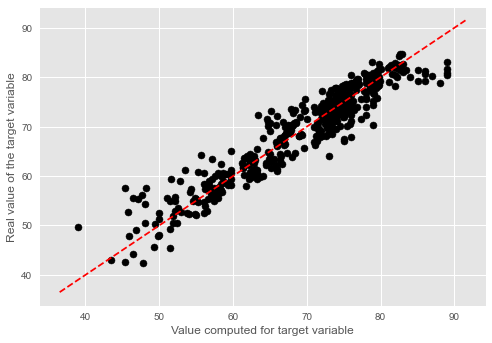

In [22]:
Visualizer.visualize_residue_line(Y_test, Y_pred)

Finally, it is possible to try to improve the model by using a variety of techniques. For instance, by using cross validation in the same scenario analyzed up to this point, one obtains the following model:

In [23]:
Algorithms.cross_val_score_model(X, Y, 'LinearRegression')

R-squared value: 0.8875090543384884
Root mean squared error: 3.2652354018122565
Normalized root mean squared error: 0.061958926030593095


That concludes the discussion about the first ML model. Next, a new model will be created and, after that, both models will be compared to each other.

## Random Forest

In order to obtain better results, it is important to try and test different prediction algorithms. On this section, the one adopted will be the Random Forest Regressor

In [24]:
model2 = Algorithms.train_Random_Forest_model(X_train, Y_train)

R-squared value (training): 0.9945487045456529


The results above show that the model created has an R-squared value of almost 1, a very high value. Next, this model will be applied to the test data:

In [25]:
Y_pred = Algorithms.test_Random_Forest_model(X_test, Y_test, model2)

R-squared value: 0.9743682633832786
Root mean squared error: 1.5444790457391344
Normalized root mean squared error: 0.03702366108301695


Focusing on the same three metrics as before, one can conclude that the later model has a higher prediction capability. Furthermore, the residues of this model can be observed below:

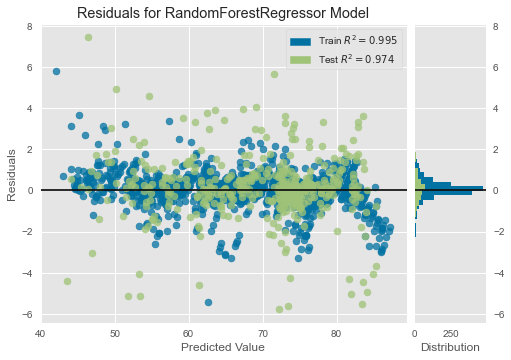

In [26]:
Visualizer.visualize_residue_spread(model2, X_train, X_test, Y_train, Y_test)

The values of the residues are highly concentrated next to zero - with a spred way lower than the one observed on the first model. This difference can also be observed on the next figure:

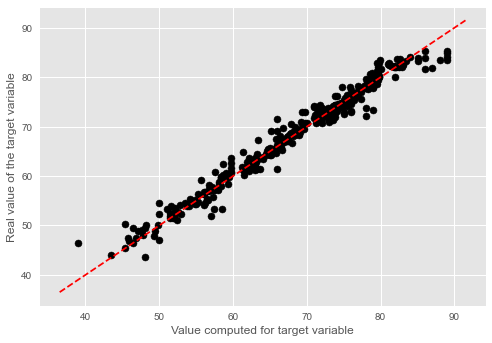

In [27]:
Visualizer.visualize_residue_line(Y_test, Y_pred)

Finally, this model can also be improved with the help of cross validation score:

In [28]:
Algorithms.cross_val_score_model(X, Y, 'RandomForest')

R-squared value: 0.9623548701862747
Root mean squared error: 1.8598116992541545
Normalized root mean squared error: 0.03529054457787769


Thus, the metrics we used point that, in every scenario considered in the cross validation, the random forest model is superior to the linear model.

## Conclusion

Among the variables in the dataset, the column Hiv/aids is the one with the strongest negative correlation with life expectancy, while the variables Years_in_school and Inc_comp_resources have the most significant positive correlation (that does not indicates causality). Still, other variables also have considerable influence on the life expectancy value and were instrumental in building both ML models.

Another important point is that the two Machine Learning models created had very good results: the first had a $ R^2 $ value around 0.89 and a RMSE between 3.0 and 3.2, while for the second one those values were about 0.96 and between 1.8 and 2.0. Thus, one can say that the second model is superior to the first.

It is very interesting to notice how a study as simple as this one could be used to establish guidelines regarding public policies. In fact, it is indisputable how a through data analysis was able to provide a clearer picture of the problem discussed here, from the relation between the data until the understanding about the effect that each variable has on the target variable. This shows how Data Analysis and Machine Learning models are essential tools for companies (and even nations) to adopt during their decision making processes.